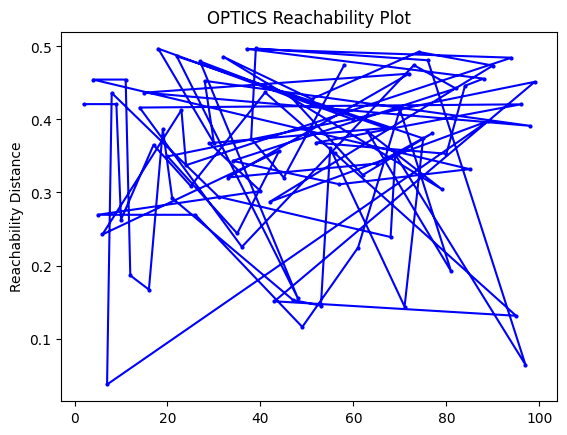

Cluster labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


In [1]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

class OPTICS:
    def __init__(self, eps, min_pts):
        self.eps = eps
        self.min_pts = min_pts
    
    def fit(self, X):
        # Initialize variables
        self.X = X
        self.n_samples = X.shape[0]
        
        # Create an array to store reachability distances (initially set to infinity)
        self.reachability_dist = np.full(self.n_samples, np.inf)
        
        # Create an array to store core distances (initially set to None)
        # self.core_dist = np.full(self.n_samples, None)
        self.core_dist = np.full(self.n_samples, -2)
        
        # Order of points processed
        self.order = []
        
        # Cluster labels: -1 means noise, otherwise cluster number
        self.labels = np.full(self.n_samples, -1)
        
        # Set all points to unvisited
        visited = np.zeros(self.n_samples, dtype=bool)
        
        # Start from each unvisited point
        for i in range(self.n_samples):
            if not visited[i]:
                self._expand_cluster(i, visited)
        
        return self.order, self.reachability_dist, self.labels

    def _expand_cluster(self, point_idx, visited):
        # Mark the current point as visited
        visited[point_idx] = True
        
        # Get the neighbors of the point
        neighbors = self._region_query(point_idx)
        
        # If the number of neighbors is less than min_pts, mark the point as noise
        if len(neighbors) < self.min_pts:
            self.reachability_dist[point_idx] = -1  # No cluster, mark as noise
            return
        
        # Otherwise, calculate the core distance for the current point
        self.core_dist[point_idx] = self._core_distance(point_idx, neighbors)
        
        # Add the current point to the ordered list
        self.order.append(point_idx)
        
        # Set reachability distances of the neighbors
        for neighbor in neighbors:
            if not visited[neighbor]:
                # If the point is unvisited, calculate the reachability distance
                self.reachability_dist[neighbor] = self._reachability_distance(point_idx, neighbor)
        
        # Process the neighbors
        to_process = deque(neighbors)
        while to_process:
            current = to_process.popleft()
            if not visited[current]:
                visited[current] = True
                self.order.append(current)
                
                # Get the neighbors of the current point
                new_neighbors = self._region_query(current)
                
                # If the new neighbors meet the min_pts condition, check their reachability distance
                if len(new_neighbors) >= self.min_pts:
                    for new_neighbor in new_neighbors:
                        if self.reachability_dist[new_neighbor] == np.inf:
                            self.reachability_dist[new_neighbor] = self._reachability_distance(current, new_neighbor)
                            to_process.append(new_neighbor)

    def _region_query(self, point_idx):
        # Calculate the distance from the current point to all other points
        distances = np.linalg.norm(self.X - self.X[point_idx], axis=1)
        
        # Find all neighbors within epsilon (eps) distance
        neighbors = np.where(distances <= self.eps)[0]
        return neighbors

    def _core_distance(self, point_idx, neighbors):
        # The core distance is the distance to the kth closest neighbor, where k = min_pts
        distances = np.linalg.norm(self.X[neighbors] - self.X[point_idx], axis=1)
        sorted_distances = np.sort(distances)
        core_distance = sorted_distances[self.min_pts - 1] if len(sorted_distances) >= self.min_pts else np.inf
        return core_distance

    def _reachability_distance(self, point_idx, neighbor_idx):
        # Reachability distance is max(core distance of the point, distance between the point and neighbor)
        distance = np.linalg.norm(self.X[neighbor_idx] - self.X[point_idx])
        return max(self.core_dist[point_idx], distance)
    
    def plot_reachability(self):
        
        plt.plot(self.order, self.reachability_dist[self.order], 'bo-', markersize=2)
        plt.ylabel('Reachability Distance')
        plt.title('OPTICS Reachability Plot')
        plt.show()

# Example usage:
# Generate synthetic data (e.g., random 2D points)
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=42)

# Initialize the OPTICS algorithm
optics = OPTICS(eps=0.5, min_pts=5)

# Fit the model and get the order of points and reachability distances
order, reachability_dist, labels = optics.fit(X)

# Visualize the reachability plot
optics.plot_reachability()

# Optionally, print the cluster labels for each point
print("Cluster labels:", labels)


In [2]:
order

[2,
 9,
 10,
 17,
 25,
 41,
 56,
 95,
 43,
 99,
 20,
 35,
 44,
 6,
 23,
 24,
 94,
 37,
 88,
 84,
 80,
 52,
 96,
 14,
 36,
 73,
 82,
 34,
 57,
 85,
 4,
 11,
 12,
 16,
 19,
 21,
 47,
 53,
 55,
 71,
 75,
 22,
 48,
 27,
 60,
 18,
 30,
 28,
 98,
 15,
 72,
 33,
 65,
 77,
 62,
 46,
 67,
 29,
 40,
 5,
 26,
 49,
 61,
 70,
 81,
 63,
 79,
 32,
 51,
 74,
 90,
 42,
 89,
 7,
 8,
 31,
 68,
 69,
 97,
 76,
 39,
 38,
 45,
 58]

In [3]:
reachability_dist

array([-1.        , -1.        ,  0.42098941, -1.        ,  0.45459092,
        0.26946541,  0.24254615,  0.03714858,  0.43630931,  0.42098941,
        0.26285352,  0.45459092,  0.18642239, -1.        ,  0.41627643,
        0.43666987,  0.16708134,  0.36519936,  0.49694477,  0.38642737,
        0.34938514,  0.29232192,  0.48648578,  0.41288314,  0.33736574,
        0.30878282,  0.26946541,  0.47940197,  0.45285936,  0.36760952,
        0.36760712,  0.29409398,  0.48584836,  0.32050501,  0.34330442,
        0.24391653,  0.22552456,  0.49658597,  0.37378253,  0.49715986,
        0.30190367,  0.43697017,  0.28719589,  0.15105203,  0.356775  ,
        0.32041163,  0.43457137,  0.15281548,  0.15579526,  0.1158871 ,
       -1.        ,  0.42795922,  0.36817816,  0.14505024, -1.        ,
        0.36066282,  0.35362518,  0.31124378,  0.47424762, -1.        ,
        0.39980473,  0.22463532,  0.32393942,  0.38360212, -1.        ,
        0.33961707, -1.        ,  0.38826626,  0.23899563,  0.35

In [6]:
reachability_dist[order]

array([0.42098941, 0.42098941, 0.26285352, 0.36519936, 0.30878282,
       0.43697017, 0.35362518, 0.13119514, 0.15105203, 0.45152006,
       0.34938514, 0.24391653, 0.356775  , 0.24254615, 0.41288314,
       0.33736574, 0.48454342, 0.49658597, 0.4558929 , 0.44613143,
       0.35300574, 0.36817816, 0.42068087, 0.41627643, 0.22552456,
       0.47434955, 0.44249543, 0.34330442, 0.31124378, 0.33196714,
       0.45459092, 0.45459092, 0.18642239, 0.16708134, 0.38642737,
       0.29232192, 0.15281548, 0.14505024, 0.36066282, 0.14381509,
       0.37404734, 0.48648578, 0.15579526, 0.47940197, 0.39980473,
       0.49694477, 0.36760712, 0.45285936, 0.39125807, 0.43666987,
       0.46268057, 0.32050501, 0.33961707, 0.3812235 , 0.32393942,
       0.43457137, 0.38826626, 0.36760952, 0.30190367, 0.26946541,
       0.26946541, 0.1158871 , 0.22463532, 0.41367789, 0.19220388,
       0.38360212, 0.30454293, 0.48584836, 0.42795922, 0.49245361,
       0.47377216, 0.28719589, 0.39784796, 0.03714858, 0.43630

<BarContainer object of 84 artists>

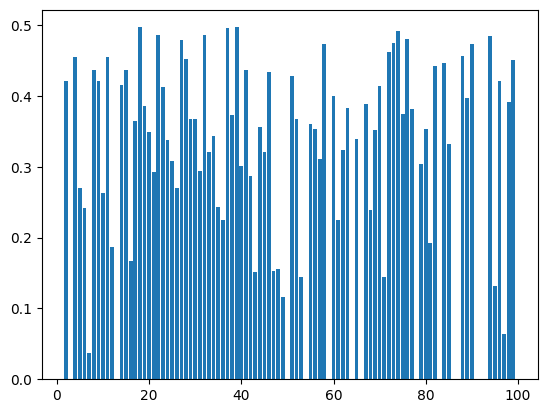

In [5]:
plt.bar(order, reachability_dist[order])

# using sklearn

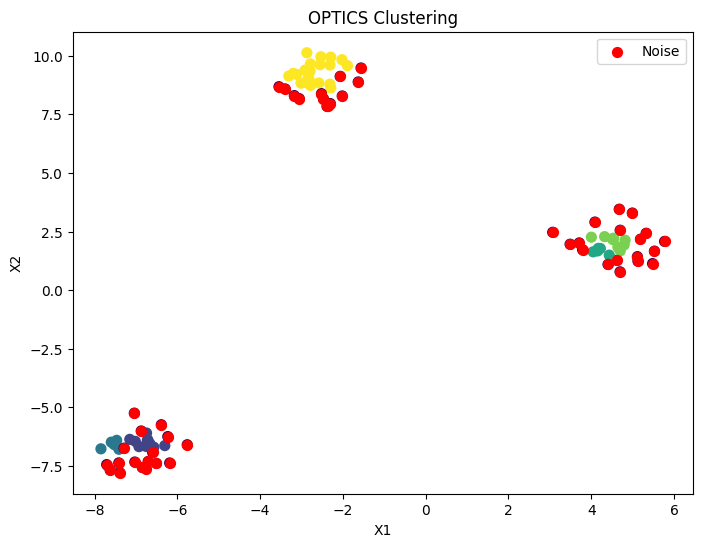

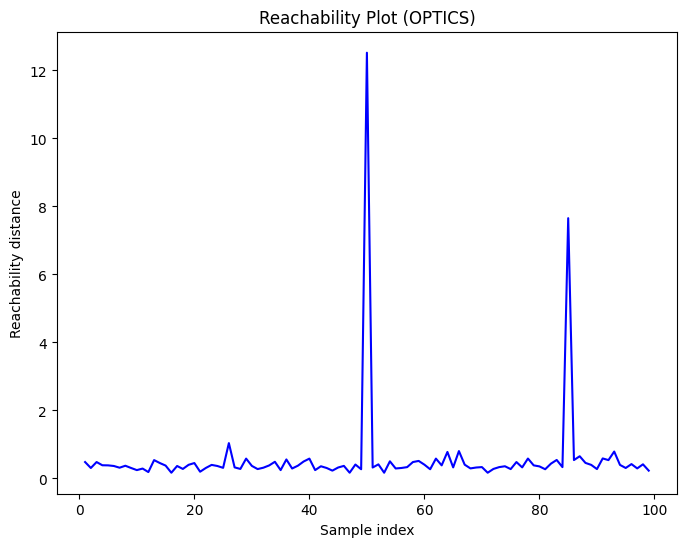

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import OPTICS

# Step 1: Generate synthetic data (e.g., 2D points)
X, _ = make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=42)

# Step 2: Apply OPTICS clustering
# eps: maximum distance between two points to be considered neighbors
# min_samples: the number of points in a neighborhood for a point to be considered a core point
optics = OPTICS(eps=0.5, min_samples=5)
optics.fit(X)

# Step 3: Get the labels and reachability distances
labels = optics.labels_  # Cluster labels (clusters are labeled 0, 1, 2, ..., -1 for noise)
reachability = optics.reachability_  # Reachability distances

# Step 4: Visualize the clustering result
plt.figure(figsize=(8, 6))

# Plot points with cluster colors
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, marker='o')

# Highlight noise points with a different color (-1 indicates noise)
plt.scatter(X[labels == -1, 0], X[labels == -1, 1], c='red', s=50, label='Noise')

plt.title('OPTICS Clustering')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

# Step 5: Reachability Plot (optional)
plt.figure(figsize=(8, 6))
plt.plot(reachability, 'b-', markersize=2)
plt.title('Reachability Plot (OPTICS)')
plt.xlabel('Sample index')
plt.ylabel('Reachability distance')
plt.show()
